In [24]:
!pip install -q --upgrade pip
!pip install -q --upgrade jupyter ipywidgets
!pip install -q --upgrade accelerate einops xformers
!pip install -q transformers datasets evaluate accelerate
!pip install -q tensorflow
!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cpu

# ~40s

SyntaxError: invalid syntax (1586165383.py, line 1)

In [2]:
!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cpu

# ~35s

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.26.post1 requires torch==2.3.0, but you have torch 2.2.2+cpu which is incompatible.


In [1]:
# Get SSIC Ref table

import pandas as pd
import os

# Get current directory
current_dir = os.getcwd()
# Get parent directory
parent_dir = os.path.dirname(current_dir)

ssic_detailed_def_filename = "ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filename = "ssic2020-alphabetical-index.xlsx"

# Define the relative path to the CSV file
ssic_detailed_def_filepath = os.path.join(parent_dir, ssic_detailed_def_filename)
ssic_alpha_index_filepath = os.path.join(parent_dir, ssic_alpha_index_filename)

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df = pd.concat([df_detailed_def, df_alpha_index])

# Prep SSIC ref-join tables
# Section, 1-alpha 
ssic_1_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# Prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# Join ssic_5 to Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')


# ssic_df prep for model

# Inspect tables
# ssic_5.head(5)
# ssic_df
# ssic_df.to_excel('SSIC Fact Ref Table.xlsx', index=False)

# Reference Table for all SSIC Layers
ref_df = df_detailed_def[['SSIC 2020','SSIC 2020 Title']]
ref_df.drop_duplicates(inplace=True)
ref_df.head()

# # Query SSIC
# ssic_query_list = ['46900', '64202', '70201', '62011', '62021']
# filtered_df = ssic_df[ssic_df['SSIC 2020'].isin(ssic_query_list)]
# filtered_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates()


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Temp\ipykernel_341

,SSIC 2020,SSIC 2020 Title
0,A,AGRICULTURE AND FISHING
1,01,AGRICULTURE AND RELATED SERVICE ACTIVITIES
2,011,"GROWING OF CROPS, MARKET GARDENING AND HORTICU..."
3,0111,Growing of Food Crops (Non-Hydroponics)
4,01111,Growing of leafy and fruit vegetables


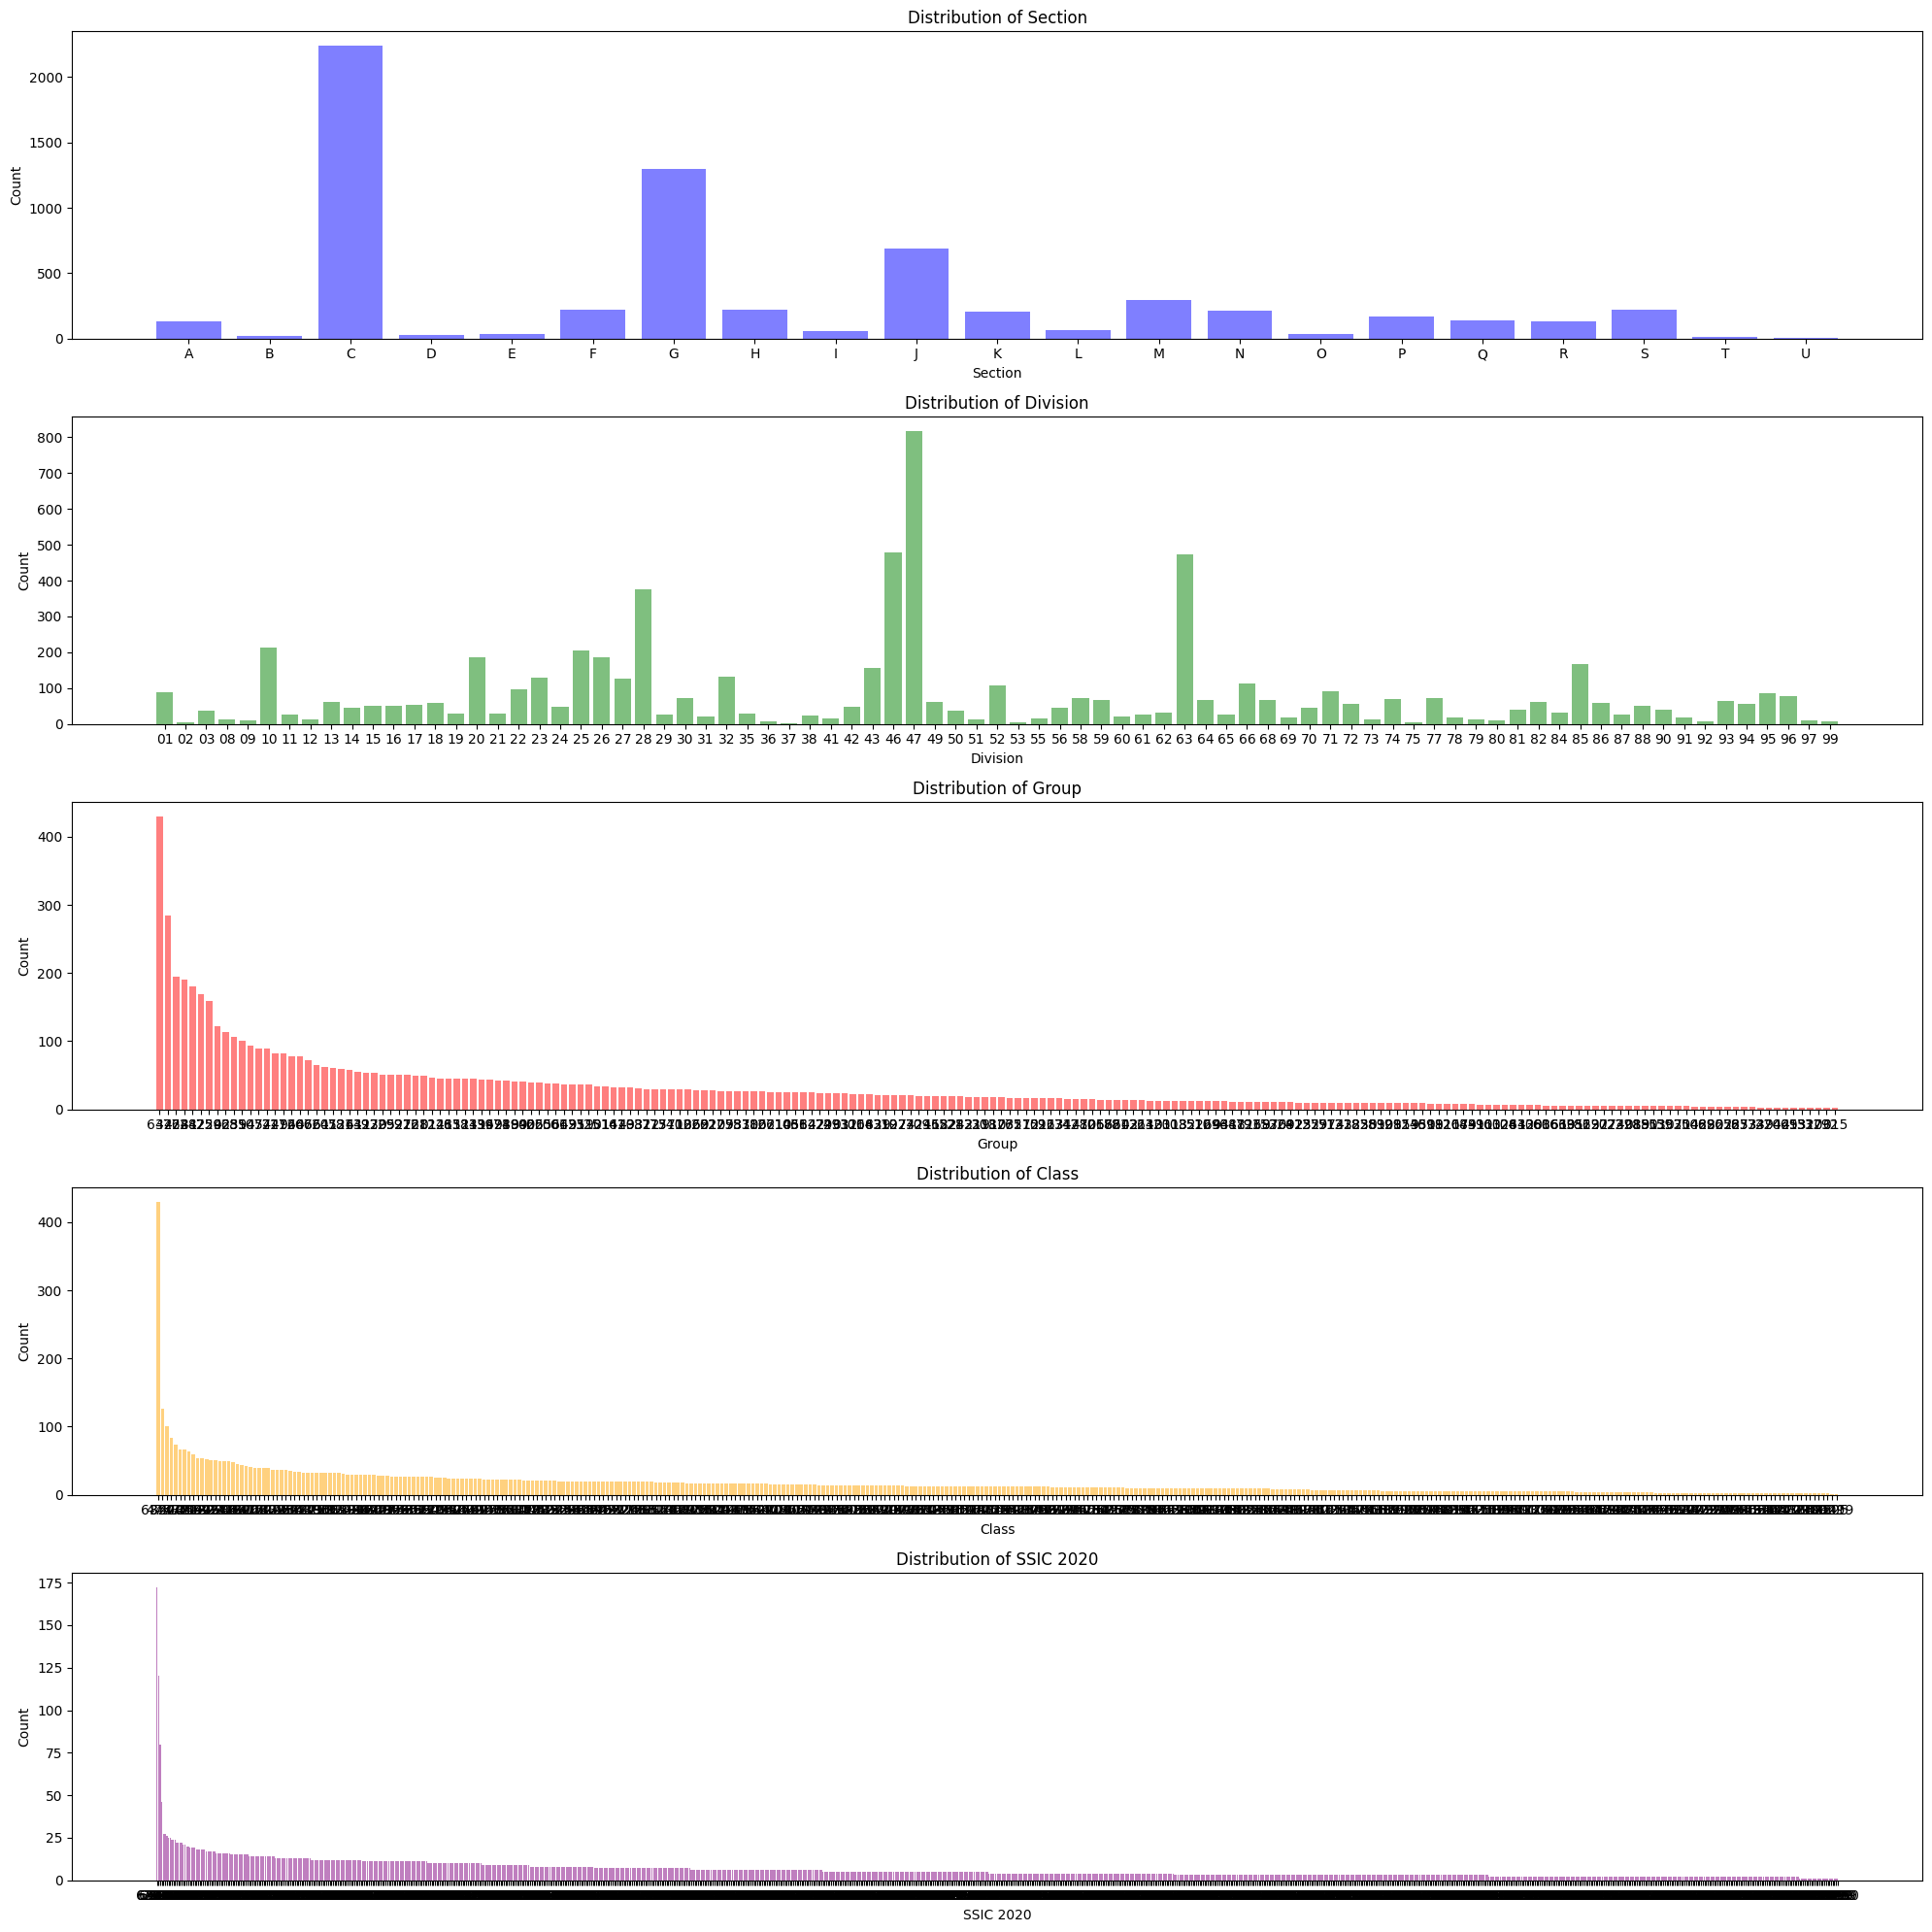

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Get count of each unique value in the 'Section' column
section_counts = ssic_df['Section'].value_counts().sort_index() # toggle .sort_index() for sorting by label or count
division_counts = ssic_df['Division'].value_counts().sort_index()
group_counts = ssic_df['Group'].value_counts()
class_counts = ssic_df['Class'].value_counts()
ssic_counts = ssic_df['SSIC 2020'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 20))

# Plot each bar chart
axes[0].bar(section_counts.index, section_counts.values, alpha=0.5, color='blue')
axes[0].set_title('Distribution of Section')
axes[0].set_xlabel('Section')
axes[0].set_ylabel('Count')

axes[1].bar(division_counts.index, division_counts.values, alpha=0.5, color='green')
axes[1].set_title('Distribution of Division')
axes[1].set_xlabel('Division')
axes[1].set_ylabel('Count')

axes[2].bar(group_counts.index, group_counts.values, alpha=0.5, color='red')
axes[2].set_title('Distribution of Group')
axes[2].set_xlabel('Group')
axes[2].set_ylabel('Count')

axes[3].bar(class_counts.index, class_counts.values, alpha=0.5, color='orange')
axes[3].set_title('Distribution of Class')
axes[3].set_xlabel('Class')
axes[3].set_ylabel('Count')

axes[4].bar(ssic_counts.index, ssic_counts.values, alpha=0.5, color='purple')
axes[4].set_title('Distribution of SSIC 2020')
axes[4].set_xlabel('SSIC 2020')
axes[4].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [2]:
# df prep for model (Group)

df_prep = ssic_df[['Group', 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep['Group'].astype('category').cat.codes

data_texts = df_prep['Detailed Definitions'].to_list() # Features (not tokenized yet)
data_labels = df_prep['encoded_cat'].to_list() # Labels

df_prep = df_prep[['Group', 'encoded_cat']].drop_duplicates()
df_prep

C:\Users\royle\AppData\Local\Temp\ipykernel_34180\1771623262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['encoded_cat'] = df_prep['Group'].astype('category').cat.codes


,Group,encoded_cat
0,011,0
10,014,1
22,015,2
23,016,3
24,020,4
...,...,...
992,952,199
1000,953,200
1003,960,201
1018,970,202


In [202]:
# https://nilg.ai/202308/classifying-text-using-llms/

##################
# LLM DistilBert #
##################

# DistilBERT for Multiclass Text Classification Using Transformers - https://medium.com/@kiddojazz/distilbert-for-multiclass-text-classification-using-transformers-d6374e6678ba
# Hugging Face Link - https://huggingface.co/distilbert/distilbert-base-uncased

In [4]:
from sklearn.model_selection import train_test_split
 
# Split Train and Validation data
# train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# 100% of Data for training
train_texts = data_texts
train_labels = data_labels
val_texts = data_texts
val_labels = data_labels
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)


In [5]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),val_labels))

# TFTrainer Class for Fine-tuning
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=204) # Indicate no. of labels/categories
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Epoch 1/2
399/399 [==============================] - 3843s 10s/step - loss: 3.5949 - accuracy: 0.2860 - val_loss: 2.2346 - val_accuracy: 0.5139
Epoch 2/2
399/399 [==============================] - 3685s 9s/step - loss: 1.7529 - accuracy: 0.6201 - val_loss: 1.0532 - val_accuracy: 0.7675


In [8]:
# Save model into folder w timestamp

from datetime import datetime
current_date = datetime.now().strftime("%d%m%y")

current_dir = os.getcwd()
# Define new folder name
new_folder_name = "distilBert Text Multiclass by 204 Groups v2 caa " +  current_date

# Create the new folder path
new_folder_path = os.path.join(current_dir, new_folder_name)

# Create the new folder if it doesn't already exist
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
    print(f"Folder '{new_folder_name}' created in {current_dir}")
else:
    print(f"Folder '{new_folder_name}' already exists in {current_dir}")

from tensorflow.keras.models import load_model
model.save_pretrained(new_folder_path)
tokenizer.save_pretrained(new_folder_path)

Folder 'distilBert Text Multiclass by 204 Groups v2 caa 070624' created in c:\Users\royle\OneDrive\Documents\GitHub\ssicsync\LLM_Test


('c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups v2 caa 070624\\tokenizer_config.json',
 'c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups v2 caa 070624\\special_tokens_map.json',
 'c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups v2 caa 070624\\vocab.txt',
 'c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups v2 caa 070624\\added_tokens.json')

In [3]:
# !pip install -q transformers datasets evaluate accelerate
# !pip install -q tensorflow
# !pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cpu

# Load model and test ~12s

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import pandas as pd

save_directory = "distilBert Text Multiclass by 204 Groups v2 caa 070624"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

# Remember to load these 2 cells!!!
# ssic_def prep for model
# df prep for model

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the mode

In [4]:
# Test

# specializes in the opening and management of diverse food outlets, aiming to create unique dining experiences while maintaining high standards of quality and service

# provides comprehensive Maintenance, Repair, and Overhaul (MRO) services for a wide range of aircraft, supported by a global network of facilities and strategic partnerships

# Singapore's regulatory authority overseeing business registration, financial reporting, and accounting standards, government

# Rakuten Group, Inc. is Japan's largest and the world's third-largest e-commerce company, offering diverse services from e-commerce to banking and professional sports, with global operations in Asia, Western Europe, and the Americas.

# boutique consultancy firm specializing in global real estate investments and wealth growth strategies

test_text = '''
A staple in the diet of many in Asia, we honour the art of bread-making by giving life to novel creations since our inception in 2000.
BreadTalk is a distinctive, award-winning Singaporean brand that has gained international appeal for its signature Flosss. With the belief that every bun has a life of its own and a story to tell, BreadTalk is renowned for the way it has revolutionised the culture of bread consumption with creativity and innovation.

At the heart of our brand, Flosss is an iconic product that has become synonymous with BreadTalk. Our range of breads goes far beyond Flosss, with new and exciting products regularly added to our lineup.


'''

from tensorflow.keras.models import load_model

predict_input = loaded_tokenizer.encode(test_text,
truncation=True,
padding=True,
return_tensors="tf")
 
output = loaded_model(predict_input)[0]

# Convert the output tensor to numpy array
output_array = output.numpy()
 
# Create a DataFrame from the output array
sorted_output_df = pd.DataFrame(output_array.T, columns=['Score']).sort_values(by='Score', ascending=False)
sorted_output_df.reset_index(inplace=True)

# Rename columns for clarity
sorted_output_df.columns = ['encoded_cat', 'Value']


# need to load ssic_df and df

section_dict = df_prep[['Group', 'encoded_cat']].drop_duplicates()
ssic_1v = ssic_3[['Group', 'Group Title']].drop_duplicates()
merged_df = section_dict.merge(ssic_1v, on= 'Group', how='left')
merged_df2 = sorted_output_df.merge(merged_df, on = 'encoded_cat', how='left')

merged_df2[['Value', 'Group', 'Group Title']].head(5)

,Value,Group,Group Title
0,1.159024,107,MANUFACTURE OF OTHER FOOD PRODUCTS
1,0.506591,463,"WHOLESALE OF FOOD, BEVERAGES AND TOBACCO"
2,0.147986,561,"RESTAURANTS, CAFES, FOOD COURTS, FOOD KIOSKS A..."
3,-0.588792,472,"RETAIL SALE OF FOOD, BEVERAGES AND TOBACCO IN ..."
4,-0.651552,106,"MANUFACTURE OF GRAIN MILL PRODUCTS, STARCHES A..."


In [5]:
# Test with List of 102

import pandas as pd
import os

# Ingest & Convert SSIC Detailed Definition Doc into df
# Get current directory
current_dir = os.getcwd()

# Get parent directory
parent_dir = os.path.dirname(current_dir)

list_102 = "Webscrap\List of 90 Coy and SSIC.csv"
list_102_AR_filename = "Webscrap\AR Report Data\extracted_notes_pages_with_uen.xlsx"

list_102_filepath = os.path.join(parent_dir, list_102)
list_102_AR_filepath = os.path.join(parent_dir, list_102_AR_filename)

df_list_102 = pd.read_csv(list_102_filepath, dtype = str)
df_list_102_AR = pd.read_excel(list_102_AR_filepath, dtype = str)

df_list_102_merged = pd.merge(df_list_102, df_list_102_AR, left_on='UEN', right_on='UEN Number')


df_list_102_merged['Division'] = df_list_102_merged['ssic_code'].astype(str).str[:2]
df_list_102_merged['Group'] = df_list_102_merged['ssic_code'].astype(str).str[:3]
df_list_102_merged['Class'] = df_list_102_merged['ssic_code'].astype(str).str[:4]
df_list_102_merged['Sub-class'] = df_list_102_merged['ssic_code'].astype(str).str[:5]
df_list_102_merged = pd.merge(df_list_102_merged, ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
df_list_102_merged.drop(columns=['Section, 2 digit code'], inplace=True)

# df_list_102_merged.head(5)

# Define the function to predict scores and categories
def predict_text(text, top_n=3):
    predict_input = loaded_tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    output = loaded_model(predict_input)[0]
    output_array = output.numpy()[0]  # Get the first (and only) output for this input
    
    # Get the top n scores and their corresponding categories
    top_n_indices = output_array.argsort()[-top_n:][::-1]
    top_n_scores = output_array[top_n_indices]
    top_n_categories = top_n_indices
    
    return [{'value': score, 'encoded_cat': category} for score, category in zip(top_n_scores, top_n_categories)]

# Create an empty list to store the predictions
predictions = []

# Iterate over each row of the DataFrame and apply the prediction function
for idx, row in df_list_102_merged.iterrows():
    text = row['Notes Page Content']
    result = predict_text(text)
    for pred in result:
        pred.update({
            'UEN': row['UEN'],
            'entity_name': row['entity_name'],
            'ssic_code': row['ssic_code'],
            'ssic_code2': row['ssic_code2'],
            'Notes Page Content': text,
            'Layer': row['Group']
        })
        predictions.append(pred)

# Create a DataFrame from the list of predictions
prediction_df = pd.DataFrame(predictions)
prediction_df = prediction_df.merge(ref_df, left_on = 'Layer', right_on = 'SSIC 2020', how = 'left')
prediction_df.drop(columns=['SSIC 2020'], inplace=True)
prediction_df = prediction_df.merge(df_prep, on = 'encoded_cat', how = 'left')
prediction_df = prediction_df.merge(ref_df, left_on = 'Group', right_on = 'SSIC 2020', how = 'left')
prediction_df.drop(columns=['SSIC 2020'], inplace=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
prediction_df


,value,encoded_cat,UEN,entity_name,ssic_code,ssic_code2,Notes Page Content,Layer,SSIC 2020 Title_x,Group,SSIC 2020 Title_y
0,1.191215,16,197803023H,ABR HOLDINGS LIMITED,47219,64202,"principal activities of the Company are the manufacture of ice cream, the operation of Swensen s ice cream parlours cum restaurants, operation of other specialty restaurants and investment holding. The principal activities of the subsidiaries are shown in Note 15. 2 Summary of significant accounting policies",472,"RETAIL SALE OF FOOD, BEVERAGES AND TOBACCO IN SPECIALISED STORES",107,MANUFACTURE OF OTHER FOOD PRODUCTS
1,0.413286,18,197803023H,ABR HOLDINGS LIMITED,47219,64202,"principal activities of the Company are the manufacture of ice cream, the operation of Swensen s ice cream parlours cum restaurants, operation of other specialty restaurants and investment holding. The principal activities of the subsidiaries are shown in Note 15. 2 Summary of significant accounting policies",472,"RETAIL SALE OF FOOD, BEVERAGES AND TOBACCO IN SPECIALISED STORES",110,MANUFACTURE OF BEVERAGES
2,-0.455197,15,197803023H,ABR HOLDINGS LIMITED,47219,64202,"principal activities of the Company are the manufacture of ice cream, the operation of Swensen s ice cream parlours cum restaurants, operation of other specialty restaurants and investment holding. The principal activities of the subsidiaries are shown in Note 15. 2 Summary of significant accounting policies",472,"RETAIL SALE OF FOOD, BEVERAGES AND TOBACCO IN SPECIALISED STORES",106,"MANUFACTURE OF GRAIN MILL PRODUCTS, STARCHES AND STARCH PRODUCTS"
3,0.737226,144,197501572K,ABUNDANCE INTERNATIONAL LIMITED,46649,18113,"principal activities of the Company are those of print and paper management related activities and investment holding. The principal activities of the subsidiaries are those of trading of commodity chemical products, provision of water treatment solutions using microbial and/or chemicals in the People s Republic of China ( PRC ), print and paper management related activities and in investment and trading of securities. The consolidated financial statements of the Group and statement of financial position of the Company for the financial year ended 31 December 202",466,OTHER SPECIALISED WHOLESALE,663,FUND MANAGEMENT ACTIVITIES
4,0.730302,138,197501572K,ABUNDANCE INTERNATIONAL LIMITED,46649,18113,"principal activities of the Company are those of print and paper management related activities and investment holding. The principal activities of the subsidiaries are those of trading of commodity chemical products, provision of water treatment solutions using microbial and/or chemicals in the People s Republic of China ( PRC ), print and paper management related activities and in investment and trading of securities. The consolidated financial statements of the Group and statement of financial position of the Company for the financial year ended 31 December 202",466,OTHER SPECIALISED WHOLESALE,649,"OTHER FINANCIAL SERVICES ACTIVITIES, EXCEPT INSURANCE AND PENSION FUNDING ACTIVITIES"
5,0.368709,142,197501572K,ABUNDANCE INTERNATIONAL LIMITED,46649,18113,"principal activities of the Company are those of print and paper management related activities and investment holding. The principal activities of the subsidiaries are those of trading of commodity chemical products, provision of water treatment solutions using microbial and/or chemicals in the People s Republic of China ( PRC ), print and paper management related activities and in investment and trading of securities. The consolidated financial statements of the Group and statement of financial position of the Company for the financial year ended 31 December 202",466,OTHER SPECIALISED WHOLESALE,661,"ACTIVITIES AUXILIARY TO FINANCIAL SERVICE ACTIVITIES, EXCEPT INSURANCE AND PENSION FUNDING"
6,0.322560,144,197902587H,ABUNDANTE LIMITED,23940,41009,"principal activities of the Company are those of an investment holding company, supply of ready- mixed concrete and 

In [ ]:
##############
# LLM Setfit #
##############

# https://huggingface.co/blog/setfit
# https://huggingface.co/mcllstr/setfit-mltclss?text=3ZB+was+a+radio+station+based+in+Christchurch%2C+New+Zealand.+This+station+was+run+by+Radio+New+Zealand+%28formally+the+NZBS%2FNZBC%2FBCNZ%29+and+eventually+spawned+a+second+FM+station+called+B98FM.
# https://github.com/huggingface/setfit

In [ ]:
!pip install -q setfit

In [ ]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer


In [ ]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset= train_texts,
    eval_dataset=val_texts,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\royle\AppData\Local\Temp\ipykernel_14304\656820149.py:5: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


AttributeError: 'list' object has no attribute 'column_names'

In [ ]:
# train_texts, val_texts, train_labels, val_labels
# train_dataset
val_dataset


<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(344,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(344,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# Load a dataset from the Hugging Face Hub
dataset = load_dataset("sst2")
dataset

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\urllib3\connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)


DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [5]:
from transformers import pipeline

summarizer_facebook_bart = pipeline("summarization", model="facebook/bart-large-cnn") # https://huggingface.co/facebook/bart-large-cnn
summarizer_falconsai = pipeline("summarization", model="Falconsai/text_summarization") # https://huggingface.co/Falconsai/text_summarization
summarizer_azma_bart = pipeline("summarization", model="Azma-AI/bart-large-text-summarizer") # https://huggingface.co/Azma-AI/bart-large-text-summarizer

ARTICLE = """ 
The principal activities of the Company are the provision of airframe maintenance, component overhaul services and inventory
technical management, the provision of line maintenance and technical ground handling services and investment holdings.
The principal activities of the subsidiary companies are disclosed in Note 18 to the financial statements. There have been no
significant changes in the nature of these activities during the financial year.
"""
print(summarizer_facebook_bart(ARTICLE, max_length=60, min_length=30, do_sample=False))
print(summarizer_falconsai(ARTICLE, max_length=60, min_length=30, do_sample=False))
print(summarizer_azma_bart(ARTICLE, max_length=60, min_length=30, do_sample=False))

[{'summary_text': 'The principal activities of the subsidiary companies are disclosed in Note 18 to the financial statements. There have been no significant changes in the nature of these activities during the financial year.'}]
[{'summary_text': 'The principal activities of the subsidiary companies are disclosed in Note 18 to the financial statements . There have been no significant changes in the nature of these activities during the financial year .'}]
[{'summary_text': 'The principal activities of the Company are the provision of airframe maintenance, component overhaul services and inventory management. The subsidiary activities are disclosed in Note 18 to the financial statements.'}]


In [6]:
from transformers import pipeline, AutoTokenizer
import torch

torch.manual_seed(0)
model = "tiiuae/falcon-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
torch.manual_seed(3)
prompt = """Permaculture is a design process mimicking the diversity, functionality and resilience of natural ecosystems. The principles and practices are drawn from traditional ecological knowledge of indigenous cultures combined with modern scientific understanding and technological innovations. Permaculture design provides a framework helping individuals and communities develop innovative, creative and effective strategies for meeting basic needs while preparing for and mitigating the projected impacts of climate change.
Write a summary of the above text.
Summary:
"""

sequences = pipe(
    prompt,
    max_new_tokens=30,
    do_sample=True,
    top_k=10,
    return_full_text = False,
)

for seq in sequences:
    print(f"{seq['generated_text']}")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The current implementation of Falcon calls `torch.scaled_dot_product_attention` directly, this will be deprecated in the future in favor of the `BetterTransformer` API. Please install the latest optimum library with `pip install -U optimum` and call `model.to_bettertransformer()` to benefit from `torch.scaled_dot_product_attention` and future performance optimizations.


KeyboardInterrupt: 